In [1]:
pwd

'/Users/erm1000255241/Library/Mobile Documents/com~apple~CloudDocs/Documents/SyracuseUniversity/4th_Quarter/IST718/Project'

In [45]:
'''
Model framework for image recognition
Data source: https://www.kaggle.com/aymenktari/flowerrecognition
Save data to working directory, define global variables, and run
'''
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import graphviz
from PIL import Image
import numpy as np
import pandas as pd
from datetime import datetime
import logging
import os
import multiprocessing
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import math

''' Global variables '''
top_dir = '/Users/erm1000255241/Library/Mobile Documents/com~apple~CloudDocs/Documents/SyracuseUniversity/4th_Quarter/IST718/Project/' # set explicitly for remote server cronjob
# top_dir = os.getcwd() # set to current directory instead if running locally
model_dict = {}
cores = 32 # cpu cores to use multiprocessing (using default parallel backend)

''' Instantiate logging '''
now = datetime.now().date()
log_path = f'{top_dir}/logs'
if not os.path.isdir(log_path):
    os.mkdir(log_path)
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S %Z',
    filename=f"{log_path}/project_{now}.log",
)
logger = logging.getLogger(__name__)

######################################################################################
# PREPROCESSING
######################################################################################

def resize_images():
    """
    Resizes the images in /train and saves them to /resized/train \n
    Folder structure is kept the same
    """
    logger.info("Resizing images")
    path = f"{top_dir}/train/"
    resize_path = f"{top_dir}/train/"
    sep = '/'
    resizeSize = (500, 800)
    for folder in os.listdir(path):
        logger.info(folder)
        files = os.listdir(path + folder)
        
        for file in files:
            try:
                if os.path.isfile(path + folder + sep + file):
                    im = Image.open(path + folder + sep + file)
                    imResize = im.resize(resizeSize, Image.ANTIALIAS)
                    newpath = resize_path + folder
                    if not os.path.isdir(newpath):
                        print('Creating dir: ' + newpath)
                        os.mkdir(newpath)
                    newpathfile = newpath + sep + file
                    imResize.save(newpathfile, format='PNG', quality=20)
            except Exception:
                logger.warning(f">>> {file} resize_images exception", exc_info=True)


def preprocess(max_folders=100, max_files=10000, resize=False):
    '''
    Returns data for images (np.array), flowers (np.array), and flower 
    categories (list) within /resized/train
    Parameters
    ----------
    count_train : number of training samples\n
    count_test : number of test samples\n
    max_folders : maximum number of folders (representing flower categories) to use\n
    max_files : maximum number of images to read from a given folder\n
    resize :  if True, call resize_images() to reduce image size before preprocessing
    '''
    logger.info("Preprocessing")
    if resize:
        resize_images()
    path = f"{top_dir}/train/"
    sep = '/'
    x_train_image, x_test_image, y_train_flower, y_test_flower, \
        x_image, y_train_labels, y_test_labels, x_train_files, x_test_files = [], [], [], [], [], [], [], [], []
    dirs = os.listdir(path)
    folder_count = 0
    for folder in dirs[:max_folders]:
        
        
        try:
            files = os.listdir(path + folder)
        except:
            continue
        file_count = 0
        nFiles = len(files)
        n_train = math.floor(nFiles * .8)
        n_test = nFiles - n_train
        
        for file in files:
            filepath = path + folder + sep + file
            if os.path.isfile(filepath):
                try:
                    im = Image.open(filepath)
                    im = np.asarray(im)
                    if im.shape == (125, 200, 3):
                        x_image.append(np.asarray(im, dtype=object).flatten())
                        if file_count < n_train:
                            x_train_image.append(
                                np.asarray(im, dtype=object).flatten())
                            y_train_flower.append(folder_count)
                            x_train_files.append(filepath)
                            y_train_labels.append(folder)
                        else:
                            x_test_image.append(
                                np.asarray(im, dtype=object).flatten())
                            y_test_labels.append(folder)
                            y_test_flower.append(folder_count)
                            x_test_files.append(filepath)
                        file_count += 1
                except Exception:
                    logger.error(f"Exception at {filepath}", exc_info=True)
#             file_count += 1
        folder_count += 1
    x_train_image = np.array(x_train_image, dtype=object)
    x_test_image = np.array(x_test_image, dtype=object)
    
    print(folder_count, file_count, len(y_train_flower),len(y_test_flower))
    
    return x_train_image, x_test_image, y_train_flower, y_test_flower, \
        x_image, y_train_labels, y_test_labels, x_train_files, x_test_files


######################################################################################
# UTILITIES
######################################################################################

def get_model_results(model, x_test, y_test, pred, x, grid=False):
    '''return dictionary of model results'''
    results = {}
    if grid:
        results['Model'] = model.best_estimator_
        results['Params'] = model.best_params_
        results['Train Accuracy'] = model.best_score_
    else:
        results['Model'] = model
        results['Params'] = model.get_params()
        results['Train Accuracy'] = 'N/A'
    return results


def get_accuracy(df):
    '''Calculates accuracy of out-of-sample model predictions on test data'''
    logger.info("Calculating accuracies")
    for col in [col for col in list(df) if col.endswith('Prediction')]:
        model = col.split('_')[0]
        correct_col = f"{model}_Correct"
        df[correct_col] = df['FlowerCategory'] == df[col]
        vals = df[correct_col].value_counts()
        model_dict[model]['Test Accuracy'] = vals[True] / sum(vals)
    return df


def print_results(y_test, pred, results):
    '''print confusion matrix'''
    for key in results:
        print(f"{key}:\t{results[key]}")
    print(f"Confusion Matrix\n{confusion_matrix(y_test, pred)}")
    

def visualize_dt(dt, x, y_labels):
    '''create visualization of the decision tree classifier'''
    dot_data = tree.export_graphviz(dt, out_file=None,
                                    feature_names=x.columns,
                                    class_names=list(set(y_labels)),
                                    filled=True,
                                    rounded=True,
                                    max_depth=3,
                                    node_ids=True,
                                    special_characters=True)
    graph = graphviz.Source(dot_data)
    # save graph to dt.pdf
    graph.render("dt")


def get_grid_search(model, grid):
    '''return GridSearchCV object'''
    grid_search = GridSearchCV(estimator = model,
                               param_grid = grid,
                               cv = 3,
                               n_jobs = min(cores, multiprocessing.cpu_count()),
                               verbose = 2,
                               refit=True
                               )
    return grid_search

def predAccuracy(actual, pred):
    acc_df = pd.DataFrame(zip(actual, pred), columns=['ac_label', 'pred_label'])
    acc_df['Correct'] = acc_df['pred_label'] == acc_df['ac_label']
    
    acc_counts = acc_df[['ac_label', 'pred_label']].groupby(['ac_label', 'pred_label']).size().unstack(fill_value=0)
    
    acc_perc = acc_counts.div(acc_counts.sum(axis=1), axis=0)*100
    
    return acc_df, acc_counts, acc_perc

######################################################################################
# MODELS
######################################################################################

######################################################################################
# Decision Tree
######################################################################################

def run_dt(x_train, x_test, y_train, y_test, x, y_labels=[]):
    '''Decision Tree Classifier
    - include y_labels in function call from main to generate visualization
    '''
    logger.info("Running DecisionTree")
    grid = {
        'max_depth': [20, 40, 60], 
        'max_features': [20, 60, 100], 
        'max_leaf_nodes': [100, 200, 300]
    }
    dt = tree.DecisionTreeClassifier(random_state = 42)
    dt = get_grid_search(dt, grid)
    dt.fit(x_train, y_train)
    dt_pred = dt.best_estimator_.predict(x_test)
    model_dict['dt'] = get_model_results(dt, x_test, y_test, dt_pred, x, grid=True)
    if y_labels:
        visualize_dt(dt, x, y_labels)
    return dt_pred


######################################################################################
# Random Forest
######################################################################################

def run_rf(x_train, x_test, y_train, y_test, x):
    '''Random Forest Classifier'''
    logger.info("Running RandomForest")
    grid = {
        'bootstrap': [True],
        'max_depth': [20, 40, 60],
        'min_samples_leaf': [50],
        'min_samples_split': [200],
        'n_estimators': [400, 600, 1000]
    }
    rf = RandomForestClassifier(random_state = 42)
    rf = get_grid_search(rf, grid)
    rf.fit(x_train, y_train)
    rf_pred = rf.best_estimator_.predict(x_test)
    model_dict['rf'] = get_model_results(rf, x_test, y_test, rf_pred, x, grid=True)
    return rf_pred

######################################################################################
# Naive Bayes
######################################################################################

def run_gnb(x_train, x_test, y_train, y_test, x):
    '''Gaussian Naive Bayes'''
    logger.info("Running GaussianNB")
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    gnb_pred = gnb.predict(x_test)
    model_dict['gnb'] = get_model_results(gnb, x_test, y_test, gnb_pred, x)
    return gnb_pred


def run_compnb(x_train, x_test, y_train, y_test, x):
    '''Complement Naive Bayes'''
    logger.info("Running ComplementNB")
    compnb = ComplementNB()
    compnb.fit(x_train, y_train)
    compnb_pred = compnb.predict(x_test)
    model_dict['compnb'] = get_model_results(compnb, x_test, y_test, compnb_pred, x)
    return compnb_pred

######################################################################################
# K-Nearest Neighbors
######################################################################################

def run_knn(x_train, x_test, y_train, y_test, x):
    '''K-Nearest Neighbors Classifier'''
    logger.info("Running KNeighbors")
    grid = {
        'algorithm': ['auto'],
        'weights': ['uniform', 'distance'],
        'p': [1, 2, 3],
        'metric': ['minkowski'],
        'n_neighbors': [2, 5, 10]
    }
    knn = KNeighborsClassifier()
    knn = get_grid_search(knn, grid)
    knn.fit(x_train, y_train)
    knn_pred = knn.best_estimator_.predict(x_test)
    model_dict['knn'] = get_model_results(knn, x_test, y_test, knn_pred, x, grid=True)
    return knn_pred

######################################################################################
# Support Vector Machine
######################################################################################

def run_svm(x_train, x_test, y_train, y_test, x):
    '''Support Vector Classification'''
    logger.info("Running SVC")
    grid = {
        'kernel': ['rbf', 'linear', 'sigmoid'], 
        'gamma': [1e-3, 1e-4],
        'C': [1, 2]
    }
    svm = SVC()
    svm = get_grid_search(svm, grid)
    svm.fit(x_train, y_train)
    svm_pred = svm.best_estimator_.predict(x_test)
    model_dict['svm'] = get_model_results(svm, x_test, y_test, svm_pred, x, grid=True)
    return svm_pred

######################################################################################

######################################################################################
# Convolutional Neural Network
######################################################################################

def run_cnn(x_train, x_test, y_train, y_test, x, retRes = False):
    '''Convolutional Neural Network Classification'''
    logger.info("Running Convolutional Neural Network")
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
    from keras.layers import Activation, Dropout, Flatten, Dense
    from keras.utils import to_categorical
    import matplotlib.pyplot as plt
    
    IMG_SIZE_x = 125
    IMG_SIZE_y = 200
    IMG_COLOR = 3
    epochs = 100
    
    cnn = Sequential()

    # First Layer
    cnn.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE_x, IMG_SIZE_y, IMG_COLOR)))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(BatchNormalization())

    # Second Layer
    cnn.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(BatchNormalization())

    cnn.add(Dropout(0.2))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(len(np.unique(y_train)), activation = 'softmax'))
    
    cnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
    y_binary_train = to_categorical(y_train)
    y_binary_test = to_categorical(y_test)
    
    history = cnn.fit(x_train.reshape(len(y_train),IMG_SIZE_x,IMG_SIZE_y,IMG_COLOR), y_binary_train, 
                    batch_size=50, 
                    epochs=epochs, 
                    verbose=1,
                    validation_data=(x_test.reshape(len(y_test),IMG_SIZE_x,IMG_SIZE_y,IMG_COLOR), y_binary_test))

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
    cnn_pred = np.argmax(cnn.predict(x_test.reshape(len(y_test),IMG_SIZE_x,IMG_SIZE_y,IMG_COLOR)), axis=-1)
    
    acc_df_train_keras, acc_counts_train_keras, acc_perc_train_keras = predAccuracy(y_test, cnn_pred)
    ax = sns.heatmap(acc_perc_train_keras, vmin=0, vmax=100, annot=True, fmt=".1f", cmap="YlGnBu")
    
    cnn.save(top_dir + 'keras_model30')
    
#     model_dict['cnn'] = get_model_results(cnn, x_test, y_test, cnn_pred, x, grid=False)
    if retRes == False:                
        return cnn_pred
    else:
        return acc_df_train_keras, acc_counts_train_keras, acc_perc_train_keras, y_test, cnn_pred

######################################################################################


In [46]:

logger.info("START")
x_train, x_test, y_train, y_test, x, y_train_labels, y_test_labels, x_train_files, x_test_files = \
        preprocess(max_folders=30)


df_results = pd.DataFrame({'CategoryName': y_test_labels, 'FlowerCategory': y_test})

# Model Selection: to exclude a model from the run, comment it out below
#     df_results['dt_Prediction'] = run_dt(x_train, x_test, y_train, y_test, x)
#     df_results['rf_Prediction'] = run_rf(x_train, x_test, y_train, y_test, x)
#     df_results['gnb_Prediction'] = run_gnb(x_train, x_test, y_train, y_test, x)
#     df_results['compnb_Prediction'] = run_compnb(x_train, x_test, y_train, y_test, x)
#     df_results['knn_Prediction'] = run_knn(x_train, x_test, y_train, y_test, x)
#     df_results['svm_Prediction'] = run_svm(x_train, x_test, y_train, y_test, x)

# df_results['cnn_Prediction'] = run_cnn(x_train, x_test, y_train, y_test, x)
# res = run_cnn(x_train, x_test, y_train, y_test, x, True)


df_results = get_accuracy(df_results)
model_summary = pd.DataFrame(model_dict).T
df_results.to_csv(f'{top_dir}/model_results.csv', index=False)
model_summary.to_csv(f'{top_dir}/model_summary.csv', index=False)
logger.info("END")

29 400 9438 2342


In [47]:
from tensorflow import keras
cnn = keras.models.load_model(top_dir + 'keras_model30')

In [48]:
# acc_df_train_keras, acc_counts_train_keras, acc_perc_train_keras = predAccuracy(y_test, res)

In [49]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 123, 198, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 99, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 99, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 48, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 48, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 48, 64)        0         
__________

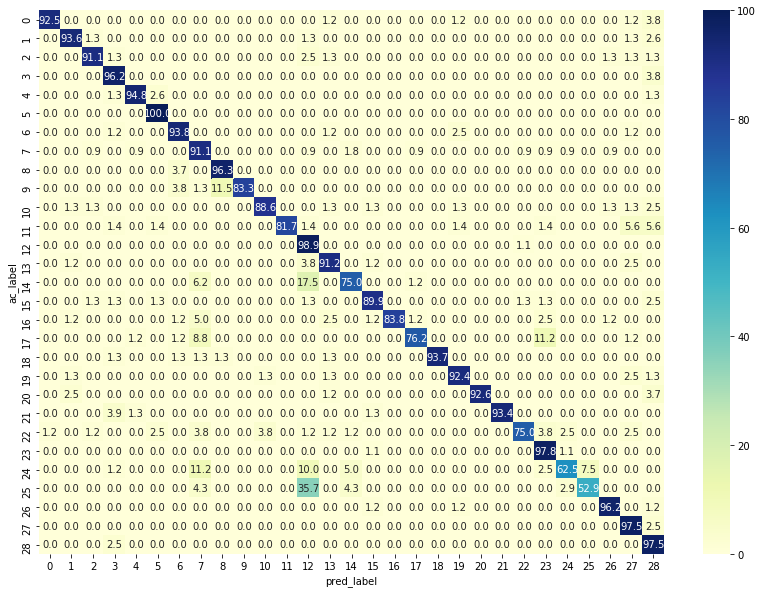

In [50]:
plt.figure(figsize=(14,10))
ax = sns.heatmap(res[2], vmin=0, vmax=100, annot=True, fmt=".1f", cmap="YlGnBu")

In [51]:
dictFlower = pd.DataFrame(zip(y_test_labels, y_test), columns=['flower', 'num']).groupby(['flower', 'num']).max().reset_index(drop=False).sort_values(['num']).reset_index(drop=True).set_index('num').to_dict()

In [52]:
dictFlower

{'flower': {0: 'chardon',
  1: 'dyrade_8_p├йtales',
  2: 'camphrier',
  3: 'buis',
  4: 'caille-lait_jaune',
  5: 'bugrane_minuscule',
  6: 'centranthe',
  7: 'asphod├иle_rameux',
  8: 'buisson_ardent',
  9: 'coquelicot',
  10: 'camomille_sauvage',
  11: 'calamenthe',
  12: 'coronille_bigar├йe',
  13: 'bugrane_rampante',
  14: 'arbre_├а_perruque',
  15: 'diphasiastrum_alpium',
  16: 'callune',
  17: 'diotis_blanc',
  18: 'cerisier',
  19: 'cakilier_maritime',
  20: 'colchique',
  21: 'camarine_noire',
  22: 'alysson_maritime',
  23: 'coronille',
  24: 'aphyllante_montpellier',
  25: 'catananche_bleue',
  26: 'buglosse_officinale',
  27: 'deutzia_rude',
  28: 'dryopteris_a_cretes'}}

In [80]:
flowerPred = res[2].copy()

In [81]:
flowerPred.columns = [dictFlower['flower'][x] for x in flowerPred.columns]

In [82]:
flowerPred['Actual'] = [x for x in flowerPred.columns]

In [83]:
flowerPred = flowerPred.set_index(['Actual'])

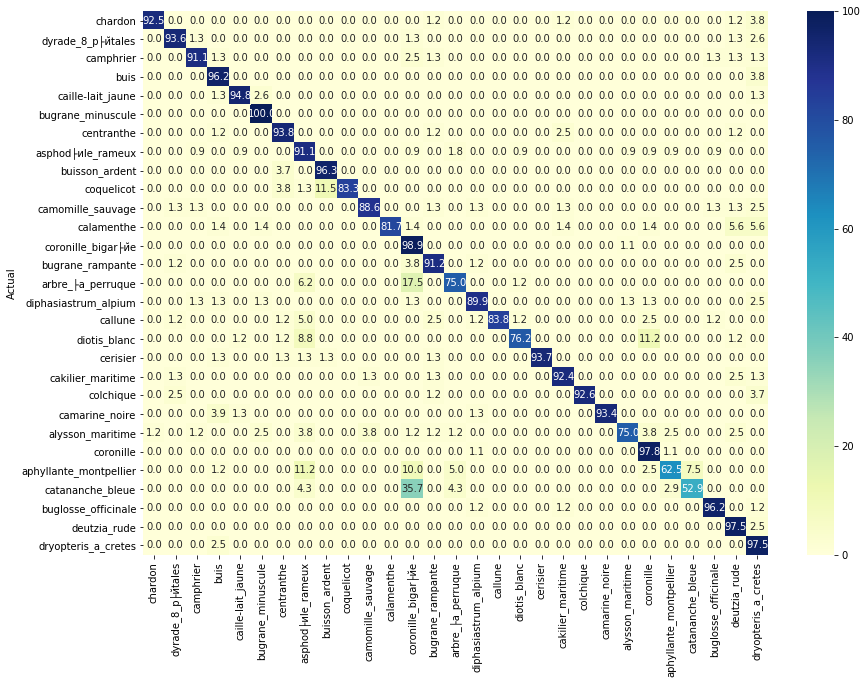

In [84]:
plt.figure(figsize=(14,10))
ax = sns.heatmap(flowerPred, vmin=0, vmax=100, annot=True, fmt=".1f", cmap="YlGnBu")

In [85]:
res[0].Correct.value_counts()

True     2082
False     260
Name: Correct, dtype: int64

In [86]:
(res[0].Correct.value_counts())/len(res[0])

True     0.888984
False    0.111016
Name: Correct, dtype: float64

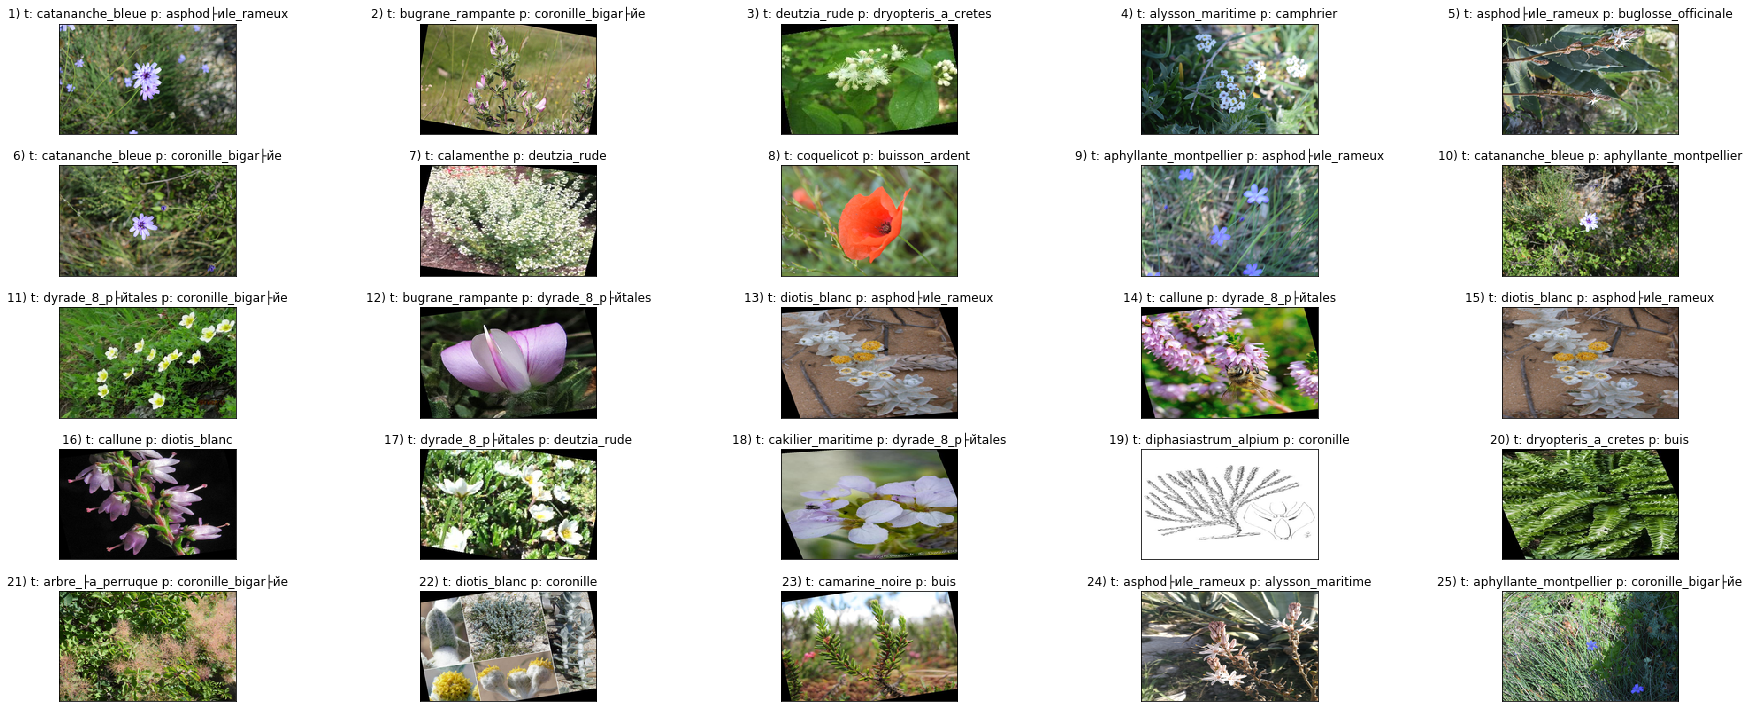

In [91]:
from matplotlib import cm
y_test_pred = res[4]

nIncorrect = len(np.array(x_test_files)[y_test != y_test_pred])
incRange = np.arange(nIncorrect)
np.random.shuffle(incRange)


miscl_img = np.array(x_test_files)[y_test != y_test_pred]
correct_lab = np.asarray(y_test)[y_test != y_test_pred]
miscl_lab= y_test_pred[y_test != y_test_pred]
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)

fig.set_figheight(10)
fig.set_figwidth(25)

ax = ax.flatten()
for i in range(25):
    img = Image.open(miscl_img[incRange[i]])
    ax[i].imshow(img)
    ax[i].set_title('%d) t: %s p: %s' % (i+1, dictFlower['flower'][correct_lab[incRange[i]]], dictFlower['flower'][miscl_lab[incRange[i]]]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_miscl.png', dpi=300)
plt.show()